# Task 3

## Imports

In [70]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torch import nn, device, no_grad
import torch.cuda
from torch.optim import Adam, AdamW
from sklearn.metrics import f1_score
import time
import os
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import torchvision.models as models
from torchvision.models import ResNet50_Weights
from torch.amp import autocast, GradScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from collections import Counter

import copy

## Dataset Helper FUnctions

In [71]:
# Custom pokemon dataset definition
class PokemonDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.img_dir, str(self.df.iloc[idx, 0]))
        if not img_name.endswith('.png'):
            img_name += ".png"
            
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        if len(self.df.columns) > 1:  # Train Set has labels, Test does not.
            label = self.df.iloc[idx, 1]
            return image, label
        else:
            return image, -1  # X dont care for Test
    
class TransformedSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
        
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        image, label = self.subset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    
def count_samples_per_class(dataset):
    """
    Counts the number of samples for each class in a given Dataset or Subset.
    Works with both raw datasets and TransformedSubset-wrapped ones.
    """
    if isinstance(dataset, torch.utils.data.Subset):
        labels = [dataset.dataset[i][1] for i in dataset.indices]
    else:
        labels = [dataset[i][1] for i in range(len(dataset))]

    class_counts = Counter(labels)
    total = sum(class_counts.values())

    print("Sample count per class:")
    for cls in sorted(class_counts):
        print(f"Class {cls}: {class_counts[cls]} samples ({class_counts[cls] / total:.2%})")

    return class_counts

## Dataset Preparation and Augmentation

In [72]:
labels = pd.read_csv("../data/train_labels.csv")
image_folder = "../data/train/"
label_encoder = LabelEncoder()
labels["label"] = label_encoder.fit_transform(labels["label"])
num_classes = len(label_encoder.classes_)
print(num_classes)

full_dataset = PokemonDataset(labels, image_folder, transform=None)
count_samples_per_class(full_dataset)

full_size = len(full_dataset)

# Kaggle Best Practices Split
labels_array = labels["label"].values
indices = np.arange(len(labels_array))

# First split: 80% train, 20% temp
train_indices, temp_indices = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels_array,
    random_state=42
)

# Second split: 10% val, 10% test from temp (which is 20%)
temp_labels = labels_array[temp_indices]
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5,  # Half of the 20%
    stratify=temp_labels,
    random_state=42
)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)



"""
# Split the dataset into 3 (70% train, 10% val, 20% test)
train_size = int(0.7 * full_size)
val_size = int(0.15 * full_size)
test_size = full_size - train_size - val_size
# Seeded generator for reproducibility
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))
"""

train_transform = transforms.Compose([
    # Convert to RGB by removing alpha channel
    transforms.Lambda(lambda x: x.convert("RGB") if x.mode == "RGBA" else x),

    #Recommended for resnet50 compatibility
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BILINEAR),
    
    # Data augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),

    # Normalize using ImageNet mean and std
    transforms.ToTensor(),
    # Based on ImageNet, recommended for the pre-trained resnet50 model
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

preprocess = transforms.Compose([
    # Convert to RGB by removing alpha channel
    transforms.Lambda(lambda x: x.convert("RGB") if x.mode == "RGBA" else x),

    #Recommended for resnet50 compatibility
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BILINEAR),
    
    # Normalize using ImageNet mean and std (since most pre-trained models use these)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_transformed = TransformedSubset(train_dataset, train_transform)
val_dataset_transformed = TransformedSubset(val_dataset, preprocess)
test_dataset_transformed = TransformedSubset(test_dataset, preprocess)

9
Sample count per class:
Class 0: 150 samples (12.56%)
Class 1: 60 samples (5.03%)
Class 2: 114 samples (9.55%)
Class 3: 159 samples (13.32%)
Class 4: 72 samples (6.03%)
Class 5: 222 samples (18.59%)
Class 6: 66 samples (5.53%)
Class 7: 99 samples (8.29%)
Class 8: 252 samples (21.11%)


## Model definition

In [73]:
class VGG16TransferLearning(nn.Module):
    def __init__(self, num_classes):
        super(VGG16TransferLearning, self).__init__()
        # Load pre-trained VGG16 model
        self.model = models.vgg16(weights="DEFAULT")
        
        # Freeze all layers in the pre-trained VGG16 model
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Unfreeze the last few layers of the model (fine-tuning)
        for param in self.model.classifier[6].parameters():
            param.requires_grad = True
        
        # Modify the final fully connected layer
        self.model.classifier[6] = nn.Sequential(
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)
    
# Create the model using transfer learning
class PokemonTypeClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PokemonTypeClassifier, self).__init__()

        self.model = models.resnet50(weights="DEFAULT") 


        in_features = self.model.fc.in_features 
        self.model.fc = nn.Sequential( 
              nn.Linear(in_features, 512),
              nn.ReLU(),
              nn.Dropout(0.5),
              nn.Linear(512, num_classes)
        )
        #CHANGED
        # Freeze all layers up to the last block
        for name, param in self.model.named_parameters():
            if 'layer3' not in name and 'layer4' not in name:
                param.requires_grad = False
        
    def forward(self, x):
        return self.model(x)

batch_size = 32
n_epochs = 80
learning_rate = 0.0001

model = PokemonTypeClassifier(num_classes)
#odel = VGG16TransferLearning(num_classes)
criterion = nn.CrossEntropyLoss()

#AFTER
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

using_gpu = torch.cuda.is_available()
pin_memory = True if using_gpu else False
num_workers = min(os.cpu_count() // 2, 8)

indices = train_dataset_transformed.subset.indices
train_labels = [full_dataset[i][1] for i in indices]
train_labels = np.array(train_labels)
class_counts = np.bincount(train_labels)
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for label in train_labels]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


train_loader = DataLoader(train_dataset_transformed, batch_size=batch_size, sampler=sampler, 
                          num_workers=num_workers, pin_memory=pin_memory)


val_loader = DataLoader(val_dataset_transformed, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset_transformed, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

device = device("cuda" if using_gpu else "cpu")
print(device)

# (0.5 = soften weights)
class_weights = class_weights / class_weights.sum() * len(class_counts)  # Normalize

#T = 0.5
#class_weights = class_weights ** T
#class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
#criterion = nn.CrossEntropyLoss(weight=class_weights) --> Not working, worse results by quite a lot.

cuda


## Training

In [74]:
def evaluate_model(model, data_loader, criterion, device):
    """Evaluate model performance on given data loader"""
    model.eval()
    correct, total = 0, 0
    all_labels = []
    all_preds = []
    test_loss = 0.0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average="macro")
    confusion = confusion_matrix(all_labels, all_preds)
    
    print(f"Test Results:")
    print(f"Loss: {test_loss/len(data_loader):.4f}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.4f}")
    
    report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
    per_class_f1 = {k: v["f1-score"] for k, v in report.items() if k.isdigit()}
    print("Per-class F1 scores:")
    for cls, score in per_class_f1.items():
        print(f"Class {cls}: {score:.4f}")
        
    return {
        "accuracy": accuracy,
        "f1_score": f1,
        "confusion_matrix": confusion
    }

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, 
                scheduler, device, n_epochs, patience=5):
    """Training function with early stopping and fine-tuning"""
    
    # Move model to device
    model.to(device)
    
    # Initialize the scaler for mixed precision training
    scaler = GradScaler(device.type)
    
    # Initialize variables for early stopping
    best_f1 = 0.0
    counter = 0
    best_model_state = None
    
    # Training metrics for plotting
    train_losses = []
    val_f1_scores = []
    
    start_time = time.time()

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
            
            # Mixed precision training
            with autocast(device.type):
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            # Backward and optimize with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        all_labels = []
        all_preds = []
        val_loss = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, preds = torch.max(outputs, 1)  # Get predicted class indices
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        f1 = f1_score(all_labels, all_preds, average="macro")
        val_f1_scores.append(f1)
        
        # MONITORING
        report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
        per_class_f1 = {k: v["f1-score"] for k, v in report.items() if k.isdigit()}
        print("Per-class F1 scores:")
        for cls, score in per_class_f1.items():
            print(f"Class {cls}: {score:.4f}")
        
        scheduler.step(avg_val_loss)
        
        # Print epoch results
        print(f"Epoch [{epoch+1}/{n_epochs}], "
                f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
                f"F1 Score: {f1:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

        
        # Early stopping logic
        if f1 > best_f1:
            best_f1 = f1
            counter = 0
            #best_model_state = model.state_dict().copy()
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"New best F1 score: {best_f1:.4f}")
        else:
            if epoch >= 9:
                counter += 1
                print(f"EarlyStopping counter: {counter} out of {patience}")
            
            if counter >= patience:
                print("Early stopping")
                break
    
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Training completed in {execution_time:.2f} seconds")
    
    # Load best model for testing
    model.load_state_dict(best_model_state)
    
    # Test loop
    test_metrics = evaluate_model(model, test_loader, criterion, device)
    
    return model, {"train_losses": train_losses, 
                   "val_f1_scores": val_f1_scores, 
                   "test_metrics": test_metrics}

final_model, train_results = train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, device, n_epochs, patience=10)

Per-class F1 scores:
Class 0: 0.2449
Class 1: 0.0000
Class 2: 0.1333
Class 3: 0.0000
Class 4: 0.1026
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.0000
Class 8: 0.0000
Epoch [1/80], Train Loss: 2.1908, Val Loss: 2.2074, F1 Score: 0.0534, LR: 0.000100
New best F1 score: 0.0534
Per-class F1 scores:
Class 0: 0.2340
Class 1: 0.0000
Class 2: 0.0000
Class 3: 0.0000
Class 4: 0.1081
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.0000
Class 8: 0.0000
Epoch [2/80], Train Loss: 2.1811, Val Loss: 2.2043, F1 Score: 0.0380, LR: 0.000100
Per-class F1 scores:
Class 0: 0.2985
Class 1: 0.0000
Class 2: 0.1622
Class 3: 0.0000
Class 4: 0.0833
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.0000
Class 8: 0.0000
Epoch [3/80], Train Loss: 2.1396, Val Loss: 2.2155, F1 Score: 0.0604, LR: 0.000100
New best F1 score: 0.0604
Per-class F1 scores:
Class 0: 0.2692
Class 1: 0.2857
Class 2: 0.2424
Class 3: 0.0000
Class 4: 0.0625
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.0000
Class 8: 0.0000
Epoch [4/80], Train Loss: 2.0944, Val L

## Visualizations

Test Results:
Loss: 1.3367
Accuracy: 64.71%
F1 Score: 0.5817
Per-class F1 scores:
Class 0: 0.5185
Class 1: 0.4000
Class 2: 0.8333
Class 3: 0.6842
Class 4: 0.3636
Class 5: 0.6939
Class 6: 0.4000
Class 7: 0.6250
Class 8: 0.7170


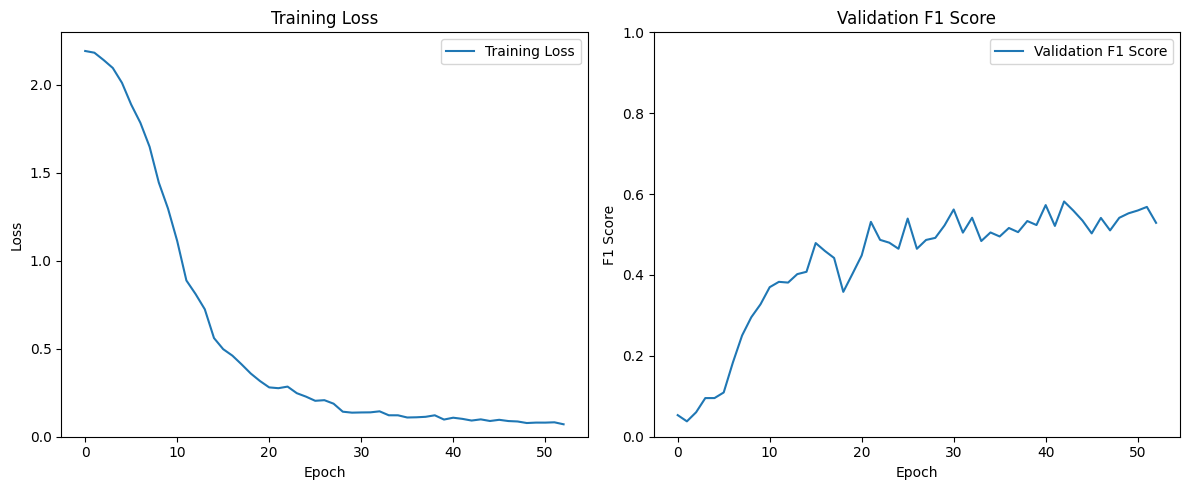

In [75]:
val_metrics = evaluate_model(final_model, val_loader, criterion, device)

# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_results['train_losses'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(bottom=0)  # Set y-axis to start at 0
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_results['val_f1_scores'], label='Validation F1 Score')
plt.title('Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim(bottom=0, top=1.0)  # Set y-axis to start at 0 and max at 1.0 (F1 range)
plt.legend()

plt.tight_layout()
plt.show()

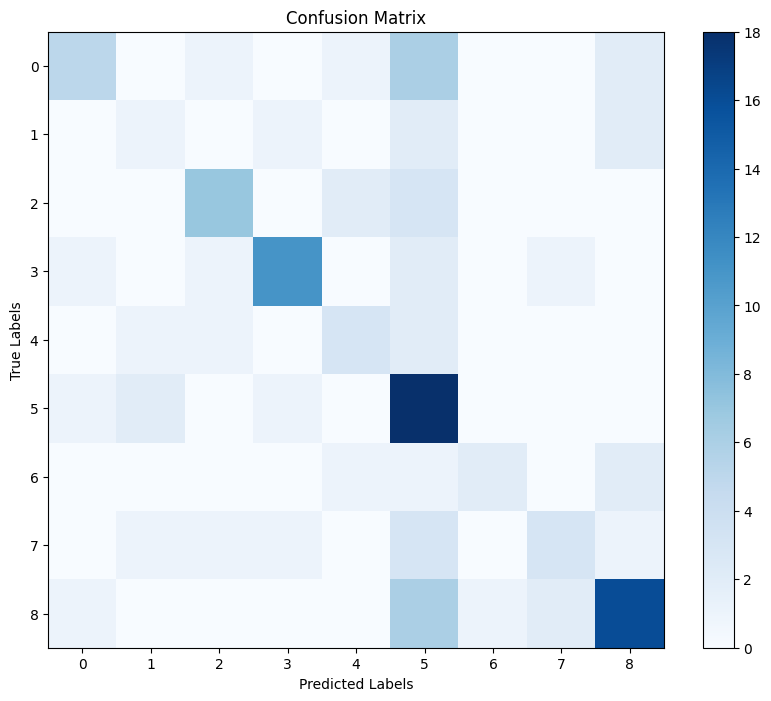

In [76]:
# Plot confusion matrix
conf_matrix = train_results['test_metrics']['confusion_matrix']
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Testing

In [77]:
# Define the correct test transform matching training/validation
test_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB") if x.mode == "RGBA" else x),
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prepare test data
test_folder = "../data/test"
test_files = [f for f in os.listdir(test_folder) if f.endswith('.png')]
test_df = pd.DataFrame({'Id': test_files})

# Create test dataset and loader
test_dataset = PokemonDataset(test_df, test_folder, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

# Predict
predictions = []
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())

# Create submission file
submission = pd.DataFrame({
    'Id': [file.split('.')[0] for file in test_files],
    'Category': label_encoder.inverse_transform(predictions)
})
submission.to_csv("task3_submit.csv", index=False)
